# Binary Classification: German Credit Dataset

This is a dataset containing 1000 samples, with features such as credit amount and duration, residence, gender, age etc, which are used to predict the credit rating of a person into good or bad. The credit rating is thus the target label with class 0 indicating bad credit rating and class 1 indicating good credit rating.

A preprocessed version of the dataset is used for these experiments, where all categorical variables have already been onehot-encoded, while the numerical features have their raw unnormalized values.

The aim is to build a CPO model for training a binarized neural network for this dataset and finally improve the model by adding constraints that ensure robustness wrt to perturbations of the training examples. In this dataset, robustness is defined with respect to the credit amount and credit duration variables, imposing constraints that small perturbations to these variables alone should not cause a change in the predicted class. 

Keeping in mind the issue of scalability that arises while working with CPO, only small samples have been used for training, while all remaining examples are a part of the validation or test set.

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import larq as lq
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from larq.layers import QuantDense
from larq import layers
from keras_tuner.tuners import RandomSearch
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.feature_selection import mutual_info_classif
from keras.callbacks import EarlyStopping
import math
import shap
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model
import random
%matplotlib inline

2024-08-21 09:54:52.910002: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 09:54:52.937829: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 09:54:52.938521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 09:54:56.796146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Preprocessing and EDA

In [2]:
# Load the dataset
df = pd.read_csv('german_credit_fullOneHot.csv')
df.head()

,credit_rating,credit_duration_months,credit_amount,installment_rate(perc_disp_income),residence_duration,age,bank_credits,dependents,telephone_yes,foreign_worker_yes,...,other_credits_bank,other_credits_none,other_credits_stores,apartment_type_for_free,apartment_type_own,apartment_type_rent,occupation_highly-qualified,occupation_skilled-employee,occupation_unemployed-non-resident,occupation_unskilled-resident
0,0,60,14027,4,2,27,1,1,1,1,...,0,1,0,0,1,0,1,0,0,0
1,0,18,1882,4,4,25,2,1,0,1,...,1,0,0,0,0,1,0,1,0,0
2,1,18,1473,3,4,39,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
3,1,24,3069,4,4,30,1,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4,1,12,763,4,1,26,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 62 columns):
 #   Column                                                         Non-Null Count  Dtype
---  ------                                                         --------------  -----
 0   credit_rating                                                  1000 non-null   int64
 1   credit_duration_months                                         1000 non-null   int64
 2   credit_amount                                                  1000 non-null   int64
 3   installment_rate(perc_disp_income)                             1000 non-null   int64
 4   residence_duration                                             1000 non-null   int64
 5   age                                                            1000 non-null   int64
 6   bank_credits                                                   1000 non-null   int64
 7   dependents                                                     1000 non-null   

##### Checking if the dataset is balanced

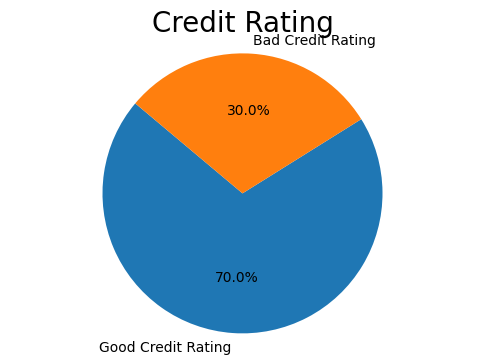

In [4]:
cr1 = (df[df.columns[0]] == 1.0).sum()
cr0 = (df[df.columns[0]] == 0.0).sum()

sizes = [cr1, cr0]
labels = ['Good Credit Rating', 'Bad Credit Rating']

plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title('Credit Rating', fontsize = 20)

plt.axis('equal')
plt.show()

We observe that the dataset is imbalanced, having a much lower proportion of the class 0. So, we will have to use SMOTE(Synthetic Minority Oversampling Technique) to ensure good performance of the Binarized Neural Network.

In [6]:
df_train, df_test = train_test_split(df,train_size=0.3,random_state=42)
df_train, df_val = train_test_split(df_train,train_size=0.534,random_state=42)

In [7]:
df_train['credit_rating'].value_counts()

credit_rating
1    124
0     36
Name: count, dtype: int64

In [8]:
x_train = df_train[df_train.columns[1:]]
y_train = df_train[df_train.columns[0]]

##### Using SMOTE to oversample the negative class

In [9]:
k_neighbors = min(4, y_train.value_counts().min()-1)

# Initialize SMOTE with the adjusted k_neighbors
sm = SMOTE(k_neighbors=k_neighbors, random_state=42)

# Apply SMOTE to the dataset
x_train, y_train = sm.fit_resample(x_train, y_train)

# Check the resampled dataset shape
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({1: 124, 0: 124})


In [10]:
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
df_train = pd.concat([x_train,y_train],axis=1)

##### Discarding columns having a single value throughout the training dataset

Columns having a single value throughout the training dataset would be redundant and should be dropped.

In [11]:
for col in x_train.columns.tolist():
    if df_train[col].nunique() == 1:
        print("Dropping column: {}".format(col))
        df.drop(col, axis=1, inplace=True)
        df_train.drop(col, axis=1, inplace=True)
        df_test.drop(col, axis=1, inplace=True)
        df_val.drop(col, axis=1, inplace=True)

Dropping column: credit_purpose_domestic_appliances
Dropping column: credit_purpose_retraining


##### Dropping one column each for binary features

For binary features, a single column is sufficient to indicate the value of the feature. So for all binary features, we retain only one column each.

In [13]:
df_train = df_train.drop(columns=['telephone_no','foreign_worker_no'])
df_test = df_test.drop(columns=['telephone_no','foreign_worker_no'])
df_val.drop(columns=['telephone_no','foreign_worker_no'],inplace=True)

##### Discarding one out of each pair of highly correlated features

In [14]:
correlation_matrix = df_train[df_train.columns[1::]].corr()

# Step 2: Create a mask to get the upper # data (as pandas dataframes)triangle of the correlation matrix, excluding the diagonal
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_triangle_matrix = correlation_matrix.where(upper_triangle_mask)

# Step 3: Extract pairs of features with the absolute correlation >= 0.9
correlated_pairs = upper_triangle_matrix.stack().reset_index()

# Rename the columns for clarity
correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlated_pairs = correlated_pairs[correlated_pairs['Correlation'].abs() >= 0.8]

print(correlated_pairs)

Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


In [15]:
features_to_drop = set()

# Iterate over the correlated pairs
for feature_1, feature_2, _ in correlated_pairs.values:
    # If neither feature is already in the drop list, add one of them (say, feature_2)
    if feature_1 not in features_to_drop and feature_2 not in features_to_drop:
        features_to_drop.add(feature_2)

# Step 5: Drop the identified features from the dataframe
df_train.drop(columns=features_to_drop,inplace=True)
df_test.drop(columns=features_to_drop,inplace=True)
df_val.drop(columns=features_to_drop,inplace=True)

print("Features dropped:", features_to_drop)
print("Shape of the new dataframe:", df_train.shape)

Features dropped: set()
Shape of the new dataframe: (248, 58)


In [16]:
x_train = df_train[df_train.columns[:-1]]
x_test = df_test[df_test.columns[1:]]
y_train = df_train[df_train.columns[-1]]
y_test = df_test[df_test.columns[0]]
x_val = df_val[df_val.columns[1:]]
y_val = df_val[df_val.columns[0]]

## Training BNN Using Keras

In [17]:
class Keras_BNN:
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.best_model = None
        self.best_hp = None
        self.weights_keras = []
        self.bin_weights_keras = []
        self.activations = []
        self.correct_prediction_list = []

    def build_model(self, hp):
        model = keras.models.Sequential()
        model.add(lq.layers.QuantDense(units=hp.Int('units_input', min_value=2, max_value=10, step=1),
                                       input_shape=(self.x_train.shape[1],),
                                       kernel_quantizer="ste_sign",
                                       kernel_constraint="weight_clip",
                                       use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        
        num_layers = hp.Int('num_layers', min_value=0, max_value=0)
        for i in range(num_layers):
            model.add(lq.layers.QuantDense(units=hp.Int(f"units_{i+1}", min_value=2, max_value=10, step=1),
                                           kernel_quantizer="ste_sign",
                                           kernel_constraint="weight_clip",
                                           input_quantizer="ste_sign",
                                           use_bias=False))
            model.add(tf.keras.layers.BatchNormalization())

        model.add(lq.layers.QuantDense(1, activation='sigmoid',
                                       kernel_quantizer="ste_sign",
                                       kernel_constraint="weight_clip",
                                       input_quantizer="ste_sign",
                                       use_bias=False))

        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def tune_model(self, max_trials=10, executions_per_trial=3):
        tuner = RandomSearch(
            self.build_model,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            directory='my_dir',
            project_name='my_project2',
            overwrite=True
        )

        tuner.search(self.x_train, self.y_train, epochs=20, validation_data=(self.x_val, self.y_val), callbacks=[self.early_stopping])
        self.best_model = tuner.get_best_models(num_models=1)[0]
        self.best_hp = tuner.get_best_hyperparameters()[0]

        return self.best_model, self.best_hp

    def extract_accuracies(self):
        train_loss, train_acc = self.best_model.evaluate(self.x_train, self.y_train)
        test_loss, test_acc = self.best_model.evaluate(self.x_test, self.y_test)
        return train_loss, train_acc, test_loss, test_acc

    def extract_weights(self):
        best_hp_vals = self.best_hp.values
        for i in range(1, 2):
            if i > best_hp_vals['num_layers'] and (f'units_{i}' in best_hp_vals.keys()):
                del best_hp_vals[f'units_{i}']

        for i in range(0, 2 * (best_hp_vals['num_layers'] + 1) + 1, 2):
            self.weights_keras.append(self.best_model.layers[i].get_weights()[0].T.tolist())

        for i in range(0, 2 * (best_hp_vals['num_layers'] + 1) + 1, 2):
            with lq.context.quantized_scope(True):
                self.bin_weights_keras.append(self.best_model.layers[i].get_weights()[0].tolist())

        return self.weights_keras, self.bin_weights_keras

    def extract_activations(self):
        layer_names = [layer.name for layer in self.best_model.layers]
        activation_model = tf.keras.models.Model(
            inputs=self.best_model.input,
            outputs=[self.best_model.get_layer(name).output for name in layer_names]
        )
        self.activations = activation_model.predict(self.x_train)
        
        bin_activations = []
        for activation in self.activations:
            bin_activation = [[math.copysign(1, elem) for elem in a] for a in activation]
            bin_activations.append(bin_activation)
        
        return self.activations, bin_activations

    def extract_correct_prediction_list(self):
        predictions = self.best_model.predict(self.x_train)
        predicted_labels = np.round(predictions).astype(int)
        correct_prediction = (predicted_labels == self.y_train.to_numpy().reshape(-1, 1)).astype(int)
        self.correct_prediction_list = correct_prediction.flatten().tolist()

        return self.correct_prediction_list

In [19]:
trainer = Keras_BNN(x_train, y_train, x_val, y_val, x_test, y_test)
best_model, best_hp = trainer.tune_model()

best_model.save('best_model.h5')

train_loss, train_acc, test_loss, test_acc = trainer.extract_accuracies()
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

print("Best hyperparameter values:",best_hp.values)

weights_keras, bin_weights_keras = trainer.extract_weights()
print(bin_weights_keras)

activations, bin_activations = trainer.extract_activations()
print(bin_activations)

correct_prediction_list = trainer.extract_correct_prediction_list()
print(correct_prediction_list)

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.7357142567634583

Best val_accuracy So Far: 0.7404761711756388
Total elapsed time: 00h 00m 35s
22/22 [==============================] - 0s 772us/step - loss: 0.7161 - accuracy: 0.5600


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Train Loss: 0.7913529276847839, Train Accuracy: 0.6169354915618896
Test Loss: 0.7161127328872681, Test Accuracy: 0.5600000023841858
Best hyperparameter values: {'units_input': 10, 'num_layers': 0, 'learning_rate': 0.07654059321735311}
[[[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0], [-1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0], [-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, 1.0, 1.0, -1

We observe that in the above case, the training accuracy is just 50%, which shows that the model is merely guessing and not learning any patterns in the data (it is assigning a single class label of 1 to all the training examples), and since the dataset is imbalanced with a much larger proportion of examples with label 1, it achieves a good test accuracy of about 69%. One reason for this could be the widely different ranges of the different features, which haven't been normalized. Hence, we try to normalize the features and then observe the behavior of the model.

In [20]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [21]:
trainer = Keras_BNN(x_train_scaled, y_train, x_val_scaled, y_val, x_test_scaled, y_test)
best_model, best_hp = trainer.tune_model()

best_model.save('best_model.h5')

train_loss, train_acc, test_loss, test_acc = trainer.extract_accuracies()
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

print("Best hyperparameter values:",best_hp.values)

weights_keras, bin_weights_keras = trainer.extract_weights()
print(bin_weights_keras)

activations, bin_activations = trainer.extract_activations()
print(bin_activations)

correct_prediction_list = trainer.extract_correct_prediction_list()
print(correct_prediction_list)

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.6428571343421936

Best val_accuracy So Far: 0.8142857154210409
Total elapsed time: 00h 00m 36s
22/22 [==============================] - 0s 665us/step - loss: 0.8934 - accuracy: 0.6986


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Train Loss: 0.28969618678092957, Train Accuracy: 0.8951612710952759
Test Loss: 0.8934086561203003, Test Accuracy: 0.6985714435577393
Best hyperparameter values: {'units_input': 5, 'num_layers': 0, 'learning_rate': 0.024829303642439165}
[[[-1.0, -1.0, 1.0, -1.0, 1.0], [-1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, 1.0], [1.0, -1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -1.0], [1.0, -1.0, -1.0, -1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -1.0], [-1.0, 1.0, -1.0, -1.0, 1.0], [-1.0, -1.0, -1.0, -1.0, 1.0], [1.0, -1.0, -1.0, -1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, -1.0, 1.0, 1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [-1.0, -1.0, 1.0, 1.0, -1.0], [-1.0, 1.0, -1.0, -1.0, -1.0], [1.0, 1.0, 1.0, 1.0, -1.0], [1.0, 1.0, 1.0, 1.0, -1.0], [1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [-1.0, 1.0, -1.0, 1.0, 1.0], [1.0, -1.0, 1.0, 1.0, -1.0], [1.0, -1.0, -1.0, -1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, -1.0, 1.0, 1.0, -1.0], [-1.0,

## Training BNN Using CPO

The set of constraints is as follows:

$$ 

n_{0j}^{k} = x_{j}^{k} \; \forall j \in N_{0},\, k \in \mathcal{T}\\
n_{\ell j}^{k} = 2(w_{\ell j}.n_{\ell -1}^{k} \geq 0) - 1 \; \forall \ell \in \{1,\ldots,L\}, \, j \in N_{\ell},\, k \in \mathcal{T}\\
\rho |\mathcal{T}| \leq \sum_{k=1}^{|\mathcal{T}|}c_{k}, \; 0<\rho<1\\

$$

where, $\rho$ represents approximately the fraction of training examples correctly classified by the Keras model, and $c_k$ is a boolean variable with value 1 indicating correct classification of training example $k$ and value 0 indicating incorrect classification of example $k$. 

In [22]:
from docplex.cp.model import *
context.solver.agent = 'local'
#context.solver.local.execfile = 'Path to the binary cpoptimizer'
context.solver.local.execfile = '/net/phorcys/data/roc/Logiciels/CPLEX_Studio201/cpoptimizer/bin/x86-64_linux/cpoptimizer'
#context.params.set_attribute('Presolve', 'Off')
context.params.set_attribute('Workers', 12)

In [23]:
y_train=y_train.replace(0,-1)
y_test = y_test.replace(0,-1)
y_val = y_val.replace(0,-1)

### Max Margin Model

The objective function for this model is the sum of margins of all neurons in the BNN. Margin of a neurons is defined as the minimum of the absolute values of the pre-activations (unbinarized activation) of a neuron for all training examples, i.e

$$\max \sum_{\ell \in \{1,\ldots,L\}} \sum_{j \in N_{\ell}} \min_{k \in \{1,\ldots,|\mathcal{T}|\}}|w_{\ell j}.n_{\ell -1}(x^k)|$$

In [86]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 
idx_cred_amt = x_train.columns.get_loc('credit_amount') #index of credit_amount column
x_max = x_train.max()[idx_cred_amt] #extract maximum value of dataframe (present in credit_amount column)

max_margin_mdl = CpoModel(name='German Credit CP Model MM')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#first (hidden) layer activations
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for hidden layers 
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights to output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #list containing all variables


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 1000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = [] #list to store margins of all neurons of layer l
    sum_margins_l = 0 #sum of margins of neurons of layer l
    for j in range(N[l]):
        activations_j = [] #list to store activations of neurons j in layer l
        margin_j = 0 #margin of neuron j
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j) #definition of margin of a neuron
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking the symmetry for weights of first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_margin_solutions = max_margin_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [87]:
#function to compute activations for dataset x
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the test set features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist() #indices of misclassified examples
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

In [88]:
# Print intermediate solutions
objective_vals = [] #list to store objective values of all solutions found
runtimes = [] #list to store runtimes of all solutions found
numsols = []
test_acc = [] #list to store test accuracies of all solutions found

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and 
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 347 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1.88184,) , Test accuracy: 0.6657142857142857
Objective value: 349 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (1.86533,) , Test accuracy: 0.6657142857142857
Objective value: 350 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (1.85714,) , Test accuracy: 0.6657142857142857
Objective value: 352 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (1.84091,) , Test accuracy: 0.6657142857142857
Objective value: 354 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (1.82486,) , Test accuracy: 0.6657142857142857
Objective value: 358 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (1.7933,) , Test accuracy: 0.6657142857142857
Objective value: 359 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (1.78552,) , Test accuracy: 0.6657142857142857
Objective valu

In [89]:
max_margin_solution = max_margin_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

80.24193548387096


We now plot the objective values, test accuracies and runtimes to observe how all the intermediate solutions perform.

##### Plots of Performance of Max Margin Model

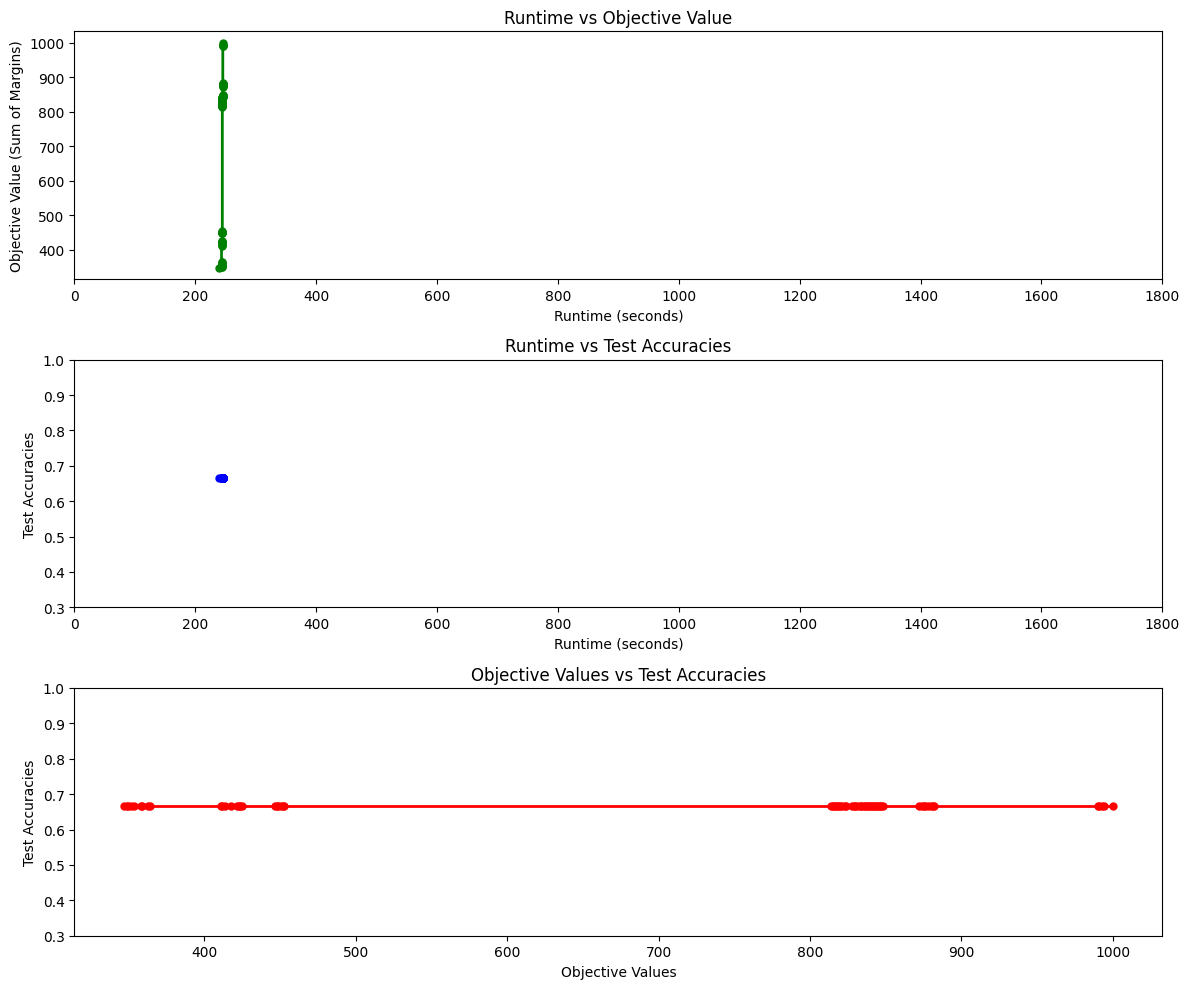

In [90]:
# Append the last point to extend up to runtime limit in case solver is unable to optimize a solution/prove optimality 
#extended_runtime = 1800
#runtimes.append(extended_runtime)
#objective_vals.append(objective_vals[-1])
#test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.3, 1.0)
plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.3, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

We observe that in this case, the solver takes some time to find the first feasible solution but is able to optimize is very fast once it is found, however, the test accuracies of all these solutions are almost the same.

We now try to give the objective a much larger upper bound and observe the performance.

In [91]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],4,10]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
idx_cred_amt = x_train.columns.get_loc('credit_amount')
x_max = x_train.max()[idx_cred_amt]

max_margin_mdl = CpoModel(name='German Credit CP Model MM')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of activations of input layer


activations.append(activations_0)

#activations and incoming weights of first hidden layer
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for further hidden layers 
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of output layer
activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #max_margin_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 10000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = []
    sum_margins_l = 0
    for j in range(N[l]):
        activations_j = []
        margin_j = 0
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j)
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking symmetry for weights of first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_margin_solutions = max_margin_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [92]:
# Print intermediate solutions
objective_vals = [] #list to store objective values of all solutions
runtimes = [] #list to store runtime values for all solutions found
numsols = []
test_acc = [] #list to store test accuracies of all solutions found

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test) #compute output activations (predictions) of test set
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy and number of misclassified test examples
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 1010 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1.07822,) , Test accuracy: 0.64
Objective value: 1062 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.97646,) , Test accuracy: 0.64
Objective value: 1063 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.9746,) , Test accuracy: 0.64
Objective value: 1064 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.972744,) , Test accuracy: 0.64
Objective value: 1065 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.970892,) , Test accuracy: 0.64
Objective value: 1066 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.969043,) , Test accuracy: 0.64
Objective value: 1067 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.967198,) , Test accuracy: 0.64
Objective value: 1069 , No. of solutions found: 8 Is solution optimal: False , Optimality gap: (0.963

In [93]:
#computing the exact training accuracy of the last obtained solution
max_margin_solution = max_margin_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

80.24193548387096


In [94]:
max_margin_solution.get_solver_infos()['TotalTime']

1783.25

In this case, the solver isn't able to optimize the solution, but the best solution found generalizes only as much as the solution found before, not better.

### Min Weight Model

In this model, the objective function used is the sum of absolute weights, i.e

$$\min \sum_{\ell \in \{1,\ldots,L\}} \sum_{i \in N_{\ell - 1}} \sum_{j \in N_{\ell}} |w_{i\ell j}|$$

where $w_{i\ell j}$ denotes the weight of the connection between neuron $j$ of layer $\ell$ to neuron $i$ from layer $\ell - 1$. 

In [72]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1

max_obj_val=0 #maximum possible value of the min weight objective
for i in range(L):
    max_obj_val+=(N[i]*N[i+1]) #max value is when absolute value of every weight variable is 1, i.e all weights are non-zero
max_obj_val
idx_cred_amt = x_train.columns.get_loc('credit_amount')
x_max = x_train.max()[idx_cred_amt]

min_weight_mdl = CpoModel(name='German Credit CP Model')

#initialize lists for storing weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0, x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#activations and weights for hidden layers 
for l in range(1, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and weights for output layer
activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = min_weight_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for atleast 75% of training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables

#define the objective
min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solution = min_weight_mdl.solve(TimeLimit=600,LogVerbosity='Terse',SearchType='Restart')

[57, 5, 1]
 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Minimization problem - 16163 variables, 17610 constraints
 ! Presolve      : 1 extractable eliminated
 ! TimeLimit            = 600
 ! Workers              = 12
 ! LogVerbosity         = Terse
 ! SearchType           = Restart
 ! Initial process time : 0.08s (0.08s extraction + 0.00s propagation)
 !  . Log search space  : 2203.8 (before), 2203.8 (after)
 !  . Memory usage      : 11.2 MB (before), 11.2 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0      16163                 -
 + New bound is 0
                        0       2027    1            -
 + New bound is 1
                     3406       1833   12   F     0 != w_4_1_1
 + New bound is 2
 *           230     178k  75.22s       5      (gap is 99.13%)
 *           2

A smaller time limit is used in this case since it was initially observed that the solver would very quickly find a solution close to the lower bound but spend a long time trying to prove optimality/find better solutions (with unrealistically small values of the min weight objective).

In [73]:
#compute exact training accuracy of the last solution found
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=min_weight_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

80.24193548387096


In [74]:
# Compute test accuracy of the solution

# Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([min_weight_solution[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Assume y_test is your true labels for the test set
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs))

Test Accuracy: 0.5857142857142857
290


### Max Accuracy Model

In this model, the objective function used is the training accuracy, i.e

$$\max \left( \frac{\sum_{k=1}^{|\mathcal{T}|}c_k }{|\mathcal{T}|} \right)$$
where $c_k$ is a boolean variable with value 1 indicating correct classification of example $k$ of the training set, and value 0 indicating misclassification of example $k$.

In [52]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1
idx_cred_amt = x_train.columns.get_loc('credit_amount') #index of the credit_amount column
x_max = x_train.max()[idx_cred_amt] #max value of the dataframe (present in credit amount column)

max_acc_mdl = CpoModel(name='German Credit CP Model 3')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #defnition of input layer activations


activations.append(activations_0)

#first hidden layer activations
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#activations and weights for further hidden layers 
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights to output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

activations.append(activations_L)
weights.append(weights_L)

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            
# breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_acc_solution = max_acc_mdl.solve(TimeLimit=1800,LogVerbosity='Terse',SearchType='Restart')

[57, 5, 1]
 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Maximization problem - 16162 variables, 17613 constraints
 ! Presolve      : 3 extractables eliminated
 ! TimeLimit            = 1800
 ! Workers              = 12
 ! LogVerbosity         = Terse
 ! SearchType           = Restart
 ! Initial process time : 0.22s (0.22s extraction + 0.00s propagation)
 !  . Log search space  : 2195.6 (before), 2195.6 (after)
 !  . Memory usage      : 11.6 MB (before), 11.6 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0       2026                 -
 + New bound is 100.0000
                        0       2026    1            -
 + New bound is 99.59716
 *      49.99999      717  0.65s        7      (gap is 99.19%)
 *      50.40322    27157  13.75s      12      (gap is 97.60%)
 *      50.80645

In [53]:
#Compute test accuracy of the solution

#Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights])

output_activations = compute_activations(weights_solution, x_test) #compute output activations (predictions) of the test set
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy and indices of misclassified examples
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs))

Test Accuracy: 0.6
280


## With Robustness Constraints

The credit amount and credit duration variables are used to define the perturbation set:

$$ S_\epsilon (x) = \{y \in \mathcal{T}| y[{ \mathcal{F}\backslash \{cred\_ amt,cred\_ dur \}}] = x[{ \mathcal{F}\backslash \{cred\_ amt,cred\_ dur\}}], |x[cred\_ amt]-y[cred\_ amt]| \leq \epsilon_{cred\_ amt}, |x[cred\_ dur]-y[cred\_ dur]|\leq \epsilon_{cred\_ dur} \}$$

The definition of robustness implies that $\forall y \in S_\epsilon(x), F(y)=F(x)$, where $F(x)$ denotes the output (prediction) of the BNN for input $x$. 

OBSERVATION: $\forall \ell \in \{1,\ldots,L\}, n_\ell (x) = n_\ell (y) \implies n_{\ell+1}(x) = n_{\ell+1}(y)$. 

So, the robustness constraint can be simplified to: $\forall y \in S_\epsilon(x), n_1(y)=n_1(x)$.

Further, if we define for each sample $x$ and neuron j in layer 1:
$$
x_{j}^{up}[i] = \begin{cases}
x[i]-\epsilon, & w_{i1j}\geq 0\\
x[i]+\epsilon, & w_{i1j}<0
\end{cases}
$$
                
$$
x_{j}^{down}[i] = \begin{cases}
x[i]+\epsilon, & w_{i1j}\geq 0\\
x[i]-\epsilon, & w_{i1j}<0
\end{cases}
$$
    
So, if neuron j is activated for sample $x$ and $x_{j}^{up}$, it is activated $\forall y \in S_{\epsilon}(x)$. If j is not activated for $x$ and $x_{j}^{down}$, then it is not activated $\forall y \in S_{\epsilon}(x)$. 

Finally, the robustness constraints can be simplified to: $\forall x \in \mathcal{T}, n_1(x_j^{up})=n_1(x_j^{down})=n_1(x)$



### Max Margin Model

In [95]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#define the lists containing x_up and x_down for each neuron j in layer 1, for all training examples x
pert_up = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]

#define the lists containing input layer activations for each example of pert_up and pert_down defined above
activations_0_up = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            #definition of input layer activations
            max_margin_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i]) 
            max_margin_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first hidden layer activations for training examples
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations for each example of pert_up and pert_down defined above
activations_1_up = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down 
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down 
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features do not change in the perturbed examples 
                max_margin_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                max_margin_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definitions of layer 1 activations
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            max_margin_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of example x and x^j_up and x^j_down

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #max_margin_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 1000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = [] #list containing margins of all neurons in layer l
    sum_margins_l = 0 #sum of margins of layer l
    for j in range(N[l]):
        activations_j = [] #list containing activations of neuron j in layer l
        margin_j = 0 #margin value of neuron j
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j) #definition of margin
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking the symmetry for weights incoming to the first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))


# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[57, 5, 1]


In [96]:
#Compute Activations for Dataset x
def compute_activations(weights_solution, x):
    activations = [x.values]  # Use the dataset features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx #return the accuracy and indices of misclassified examples

flatten = lambda l: [item for sublist in l for item in sublist]

In [97]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")

Objective value: 32 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (30.25,) , Test accuracy: 0.5971428571428572
Objective value: 33 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (29.303,) , Test accuracy: 0.5971428571428572
Objective value: 35 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (27.5714,) , Test accuracy: 0.5971428571428572
Objective value: 37 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (26.027,) , Test accuracy: 0.5971428571428572
Objective value: 38 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (25.3158,) , Test accuracy: 0.5971428571428572
Objective value: 39 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (24.641,) , Test accuracy: 0.5971428571428572
Objective value: 40 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (24,) , Test accuracy: 0.5971428571428572
Objective value: 41 , No. of s

In [98]:
#Compute exact training accuracy of last solution obtained
max_margin_solution = max_margin_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

80.24193548387096


In [99]:
max_margin_solution.get_solver_infos()['TotalTime']

1654.2

We observe that the solver is able to find multiple feasible solutions but is unable to optimize them within the time limit. So, in order to judge the quality of the intermediate solutions, we observe the plots of objective value, test accuracy and runtime.

##### Plots of Performance of Max Margin Model

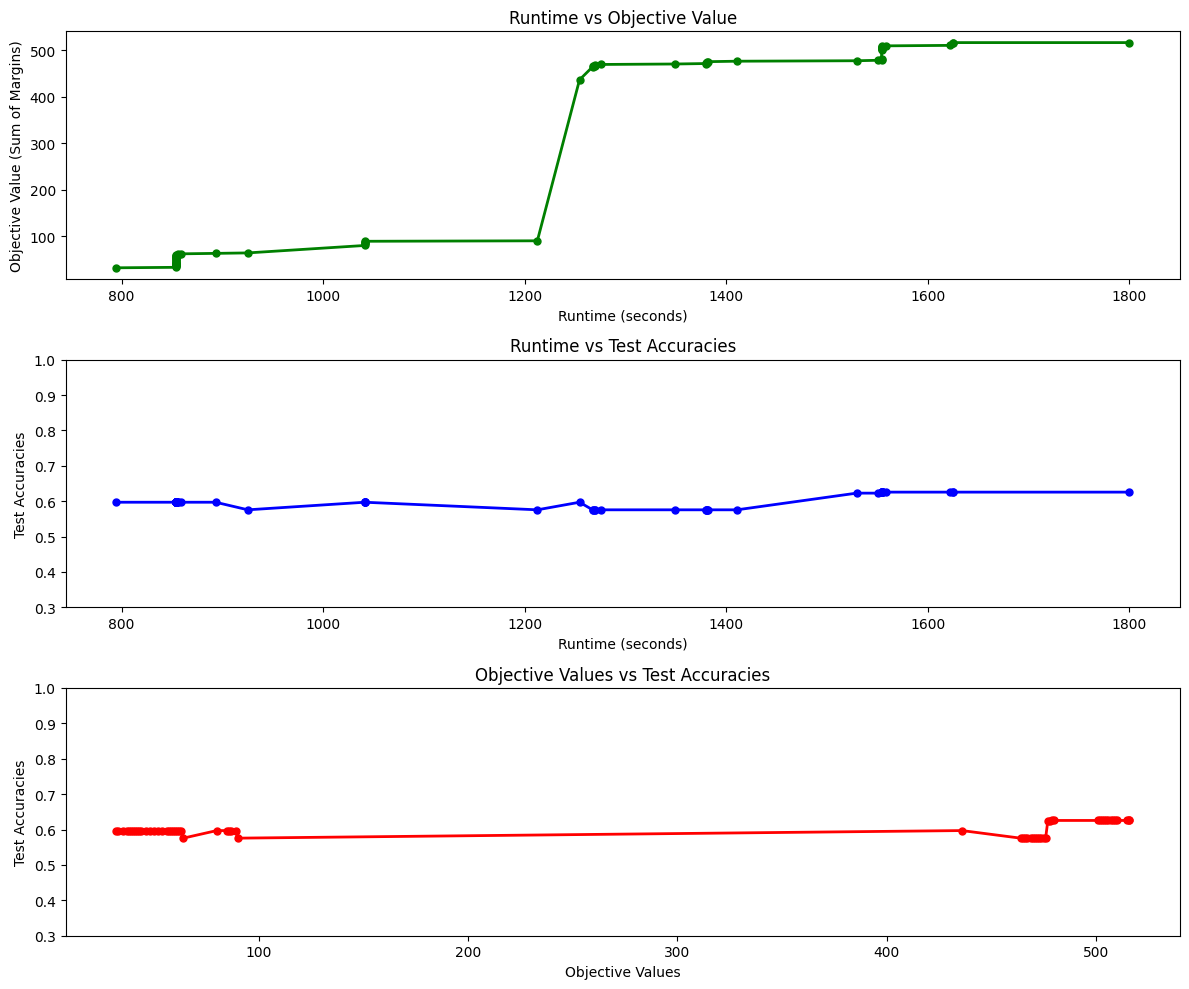

In [100]:
# Append the last point to extend up to runtime 1800
extended_runtime = 1800
runtimes.append(extended_runtime)
objective_vals.append(objective_vals[-1])
test_acc.append(test_acc[-1])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Subplot 1: Runtime vs Objective Values
plt.subplot(3, 1, 1)
plt.plot(runtimes, objective_vals, color='green', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Objective Value (Sum of Margins)")
plt.title("Runtime vs Objective Value")
#plt.xlim(0, 1800)

# Subplot 2: Runtime vs Test Accuracies
plt.subplot(3, 1, 2)
plt.plot(runtimes, test_acc, color='blue', marker='o', linewidth=2, markersize=5)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Test Accuracies")
plt.title("Runtime vs Test Accuracies")
plt.ylim(0.3, 1.0)
#plt.xlim(0, 1800)

# Subplot 3: Objective Values vs Test Accuracies
plt.subplot(3, 1, 3)
plt.plot(objective_vals, test_acc, color='red', marker='o', linewidth=2, markersize=5)
plt.xlabel("Objective Values")
plt.ylabel("Test Accuracies")
plt.title("Objective Values vs Test Accuracies")
plt.ylim(0.3, 1.0)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Min Weight Model

In [69]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],4,10]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val
idx_cred_amt = x_train.columns.get_loc('credit_amount')
idx_cred_dur = x_train.columns.get_loc('credit_duration_months')
epsilon_amt = 100
epsilon_dur = 2
x_max = x_train.max()[idx_cred_amt]

min_weight_mdl = CpoModel(name='German Credit CP Model MW')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

pert_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            min_weight_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            min_weight_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)


activations_1_up = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                min_weight_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                min_weight_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            min_weight_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i]))

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for atleast 75% of training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solutions = min_weight_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [70]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


In [72]:
min_weight_solution = min_weight_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=min_weight_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

82.78688524590164


In [73]:
min_weight_solution.get_solver_infos()['TotalTime']

123.12

#### Using Search Phases

In [60]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],4,10]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val
idx_cred_amt = x_train.columns.get_loc('credit_amount')
idx_cred_dur = x_train.columns.get_loc('credit_duration_months')
epsilon_amt = 100
epsilon_dur = 2
x_max = x_train.max()[idx_cred_amt]

min_weight_mdl = CpoModel(name='German Credit CP Model MW')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

pert_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            min_weight_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            min_weight_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)


activations_1_up = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                min_weight_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                min_weight_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            min_weight_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i]))

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for atleast 75% of training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables

# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
search_phases = [search_phase(corr_pred)]
for l in range(L, 0, -1):
    search_phases.append(search_phase(activations_flat[l]))
    search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
#search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
#weights_act=[]
#for l in range(L, 0, -1):
    #weights_act = weights_flat[l-1] + activations_flat[l-1]
    #search_phases.append(search_phase(weights_act))


# Add search phases to the model
min_weight_mdl.set_search_phases(search_phases)

#define the objective
min_weight_obj = min_weight_mdl.integer_var(10, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solutions = min_weight_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [61]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


In [62]:
min_weight_solution = min_weight_solutions.get_last_solution()
train_acc=0
for k in range(x_train.shape[0]):
    train_acc+=min_weight_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'

In [63]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],4,10]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val
idx_cred_amt = x_train.columns.get_loc('credit_amount')
idx_cred_dur = x_train.columns.get_loc('credit_duration_months')
epsilon_amt = 100
epsilon_dur = 2
x_max = x_train.max()[idx_cred_amt]

min_weight_mdl = CpoModel(name='German Credit CP Model MW')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

pert_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            min_weight_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            min_weight_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)


activations_1_up = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                min_weight_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                min_weight_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            min_weight_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i]))

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for atleast 75% of training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables

# Flatten the nested lists of activation and weight variables
flatten = lambda l: [item for sublist in l for item in sublist]

activations_flat = [flatten(layer) for layer in activations]
weights_flat = [flatten(layer) for layer in weights]


# Define the search phase 1
#search_phases = [search_phase(corr_pred)]
#for l in range(L, 0, -1):
    #search_phases.append(search_phase(activations_flat[l]))
    #search_phases.append(search_phase(weights_flat[l-1]))


# Define the search phase 2
search_phases = [search_phase(corr_pred),search_phase(activations_flat[L])]
weights_act=[]
for l in range(L, 0, -1):
    weights_act = weights_flat[l-1] + activations_flat[l-1]
    search_phases.append(search_phase(weights_act))


# Add search phases to the model
min_weight_mdl.set_search_phases(search_phases)

#define the objective
min_weight_obj = min_weight_mdl.integer_var(10, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solutions = min_weight_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [64]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Search ended successfully.


##### Lower Training Accuracy

In [67]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
#N=[x_train.shape[1],4,10]
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L))
max_obj_val=0
for i in range(L):
    max_obj_val+=(N[i]*N[i+1])
max_obj_val
idx_cred_amt = x_train.columns.get_loc('credit_amount')
idx_cred_dur = x_train.columns.get_loc('credit_duration_months')
epsilon_amt = 100
epsilon_dur = 2
x_max = x_train.max()[idx_cred_amt]

min_weight_mdl = CpoModel(name='German Credit CP Model MW')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j])


activations.append(activations_0)

pert_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            min_weight_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            min_weight_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)


activations_1_up = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                min_weight_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                min_weight_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            min_weight_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i]))

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.7*x_train.shape[0]) # constraint for atleast 75% of training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables


#define the objective
min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solutions = min_weight_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [68]:
# Print intermediate solutions
objective_vals = []
runtimes = []
numsols = []
test_acc = []

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test)
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")

Objective value: 38 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (0.973684,) , Test accuracy: 0.6042857142857143
Objective value: 19 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.947368,) , Test accuracy: 0.5857142857142857
Objective value: 14 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.928571,) , Test accuracy: 0.59
Objective value: 13 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.923077,) , Test accuracy: 0.59
Objective value: 12 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.916667,) , Test accuracy: 0.59
Objective value: 5 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.8,) , Test accuracy: 0.6171428571428571
Objective value: 4 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.75,) , Test accuracy: 0.6171428571428571
Objective value: 3 , No. of solutions found: 8 Is solution optimal

### Max Accuracy Model

In [54]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)


max_acc_mdl = CpoModel(name='German Credit CP Model MA')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of inout layer activations


activations.append(activations_0)

#lists containing perturbed examples x^j_up and x^j_down, for each neuron j of layer 1, for all training examples x
pert_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            max_acc_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            max_acc_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first hidden layer activations for training examples 
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations for perturbed examples x^j_up and x^j_down
activations_1_up = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features remain unchanged
                max_acc_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                max_acc_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definition of first layer activations
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            max_acc_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of x and x^j_up and x^j_down

#activations and weights for hidden layers
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

activations.append(activations_L)
weights.append(weights_L)

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            
#breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[57, 5, 1]


In [55]:
# Print intermediate solutions
objective_vals = [] #list to store objective values of all solutions
runtimes = [] #list to store runtimes of all solutions
numsols = []
test_acc = [] #list to store test accuracies of all solutions

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and test accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_test) #compute output activations (predictions) of test set
    test_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values) #compute test accuracy
    
    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    test_acc.append(test_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, "Is solution optimal:", solution.is_solution_optimal(), ", Optimality gap:", solution.get_objective_gaps(), ", Test accuracy:", test_accuracy)
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")

Objective value: 50 , No. of solutions found: 1 Is solution optimal: False , Optimality gap: (1,) , Test accuracy: 0.6757142857142857
Objective value: 50.4032 , No. of solutions found: 2 Is solution optimal: False , Optimality gap: (0.984,) , Test accuracy: 0.6757142857142857
Objective value: 61.2903 , No. of solutions found: 3 Is solution optimal: False , Optimality gap: (0.631579,) , Test accuracy: 0.65
Objective value: 61.6935 , No. of solutions found: 4 Is solution optimal: False , Optimality gap: (0.620915,) , Test accuracy: 0.43857142857142856
Objective value: 62.0968 , No. of solutions found: 5 Is solution optimal: False , Optimality gap: (0.61039,) , Test accuracy: 0.44
Objective value: 62.5 , No. of solutions found: 6 Is solution optimal: False , Optimality gap: (0.6,) , Test accuracy: 0.44
Objective value: 62.9032 , No. of solutions found: 7 Is solution optimal: False , Optimality gap: (0.589744,) , Test accuracy: 0.4471428571428571
Objective value: 63.3065 , No. of solutions

In [56]:
#Print test accuracy and number of misclassified test examples of last solution obtained 

max_acc_solution = max_acc_solutions.get_last_result()
# Step 1: Extract the Weights from the Solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights])

# Compute the activations for the test set
output_activations = compute_activations(weights_solution, x_test)

# Assume y_test is your true labels for the test set
flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(output_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs))

Test Accuracy: 0.65
245


In [57]:
max_acc_solution.get_solver_infos()['TotalTime']

791.67

## Improving the Robust Models Using the Validation Set

Through the plots of the test accuracies vs the optimal values of the different models, we make the following observations:
1) The solver often found feasible solutions very fast (within a few seconds) but struggled to optimize or prove optimality of a solution within the time limit. Intermediate solutions, however, often perform reasonably well on the test set.
2) The optimal solutions may not always generalize the best, i.e the test accuracies of the optimal or final solutions may not always be the highest.


Moreover, the solutions for all models generalize similar to or slightly poorer than the keras-trained BNN even with extremely small training datasets and absolutely no use of the validation set. On the other hand, the good generalization of the Keras-trained BNN can be attributed to the large validation set used, as observed at the beginning of this notebook. So, in order to improve the generalization of our CPO-trained BNNs, we will make use of the validation set in the following two ways and see if the performance improves.
1) The validation accuracies of the intermediate solutions are computed and the solution having the best validation accuracy is finally adopted ans is expected to generalize the best (i.e have the highest test accuracy too).
2) For CP $_{a}$: From the validation set, a few examples that are misclassified by the CPO model are randomly sampled (an equal number from both classes), and more constraints are then added to the model to ensure correct classification of these examples. This process is repeated a few times.

### APPROACH 1: SELECTING THE SOLUTION WITH BEST VALIDATION ACCURACY

### Max Margin Model

In [105]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)

max_margin_mdl = CpoModel(name='German Credit CP Model 2')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_margin_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_margin_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#define the lists containing x_up and x_down for each neuron j in layer 1, for all training examples x
pert_up = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]

#define the lists containing input layer activations for each example of pert_up and pert_down defined above
activations_0_up = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[max_margin_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            #definition of input layer activations
            max_margin_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i]) 
            max_margin_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first hidden layer activations for training examples
activations_1 = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations for each example of pert_up and pert_down defined above
activations_1_up = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down 
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down 
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_margin_mdl.add(max_margin_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features do not change in the perturbed examples 
                max_margin_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                max_margin_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definitions of layer 1 activations
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            max_margin_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of example x and x^j_up and x^j_down

#activations and weights for hidden layers and output layer
for l in range(2, L):
    activations_l = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)


activations_L = [[max_margin_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_margin_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [max_margin_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #max_margin_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #max_margin_mdl.add(max_margin_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_margin_mdl.add(max_margin_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
                #correct_prediction_condition = max_margin_mdl.logical_and([activations_l[k][j] == y_train.iloc[k][j] for j in range(N[l])]) 
                #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label

        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_margin_mdl.add(max_margin_mdl.if_then(max_margin_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
max_margin_mdl.add(max_margin_mdl.sum(corr_pred)>0.8*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables


# Define the objective
max_margin_obj = max_margin_mdl.integer_var(0, 1000, name='max_margin_objective')
margins_neurons = []
sum_margins = 0
for l in range(1,L+1):
    margins_l = [] #list containing margins of all neurons in layer l
    sum_margins_l = 0 #sum of margins of layer l
    for j in range(N[l]):
        activations_j = [] #list containing activations of neuron j in layer l
        margin_j = 0 #margin value of neuron j
        for k in range(x_train.shape[0]):
            elem = max_margin_mdl.scal_prod(weights[l-1][j], activations[l-1][k])
            activations_j.append(max_margin_mdl.abs(elem))
        margin_j = max_margin_mdl.min(activations_j) #definition of margin
        margins_l.append(margin_j)
    sum_margins_l += max_margin_mdl.sum(margins_l)
    sum_margins += sum_margins_l

max_margin_mdl.add(max_margin_obj == sum_margins)
max_margin_mdl.add(max_margin_mdl.maximize(max_margin_obj))

#breaking the symmetry for weights incoming to the first layer
for i in range(N[1]-1):
    max_margin_mdl.add(max_margin_mdl.lexicographic(weights[0][i],weights[0][i+1]))


# Start interactive search
max_margin_solutions = max_margin_mdl.start_search(SearchType='Restart', TimeLimit=3600, LogVerbosity='Quiet')

[57, 5, 1]


In [106]:
# Initialize variables to store the best solution
objective_vals = []
runtimes = []
numsols = []
val_acc = []

best_val_accuracy = 0
solution_best = None

# Fetch the first solution
try:
    solution = max_margin_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) for validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and number of misclassified examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher test accuracy
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = max_margin_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_margin_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 32 , No. of solutions found: 1 , Optimality gap: (30.25,) , Validation accuracy: 0.6071428571428571
Objective value: 33 , No. of solutions found: 2 , Optimality gap: (29.303,) , Validation accuracy: 0.6071428571428571
Objective value: 35 , No. of solutions found: 3 , Optimality gap: (27.5714,) , Validation accuracy: 0.6071428571428571
Objective value: 37 , No. of solutions found: 4 , Optimality gap: (26.027,) , Validation accuracy: 0.6071428571428571
Objective value: 38 , No. of solutions found: 5 , Optimality gap: (25.3158,) , Validation accuracy: 0.6071428571428571
Objective value: 39 , No. of solutions found: 6 , Optimality gap: (24.641,) , Validation accuracy: 0.6071428571428571
Objective value: 40 , No. of solutions found: 7 , Optimality gap: (24,) , Validation accuracy: 0.6071428571428571
Objective value: 41 , No. of solutions found: 8 , Optimality gap: (23.3902,) , Validation accuracy: 0.6071428571428571
Objective value: 42 , No. of solutions found: 9 , Optimali

In [107]:
#compute exact training accuracy of best solution
train_acc_best = 0
for k in range(x_train.shape[0]):
    train_acc_best+=solution_best.get_value(f'corr_pred_{k}')
print(train_acc_best*100/x_train.shape[0])

80.24193548387096


In [108]:
#Compute test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.6257142857142857
262 incorrectly classified examples out of 700 test examples


In [109]:
# Compute exact training accuracy of last solution

max_margin_solution = max_margin_solutions.get_last_solution()
train_acc= 0
for k in range(x_train.shape[0]):
    train_acc+=max_margin_solution.get_value(f'corr_pred_{k}')
print(train_acc*100/x_train.shape[0])

80.24193548387096


In [110]:
#Compute test accuracy of last solution

# Step 1: Extract the Weights from the Best Solution
weights_sol = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [max_margin_solution[weight_var] for weight_var in neuron_weights]
        weights_sol[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.6257142857142857
262 incorrectly classified examples out of 700 test examples


### Min Weight Model

In [111]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)

max_obj_val=0 #maximum possible value of min weight objective
for i in range(L):
    max_obj_val+=(N[i]*N[i+1]) #if all weights have value 1 or -1
max_obj_val

min_weight_mdl = CpoModel(name='German Credit CP Model MW')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[min_weight_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        min_weight_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of input layer activations


activations.append(activations_0)

#lists containing perturbed examples x^j_up and x^j_down for all neurons j in layer 1, for all training examples x
pert_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[min_weight_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            #definition of input layer activations
            min_weight_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            min_weight_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first layer activations for training examples
activations_1 = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations of perturbed examples in pert_up and pert_down
activations_1_up = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                min_weight_mdl.add(min_weight_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features of the perturbed examples do not change 
                min_weight_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                min_weight_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definition of first layer activations for x^j_up and x^j_down
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            min_weight_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of x and x^j_up and x^j_down

#activations and weights for further hidden layers 
for l in range(2, L):
    activations_l = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and weights incoming to output layer
activations_L = [[min_weight_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[min_weight_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]
corr_pred = [min_weight_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 
        #min_weight_mdl.add(activations_L[k][j]==y_train.iloc[k][j])
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
    #min_weight_mdl.add(min_weight_mdl.if_then(activations_l[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label


    if N[L]==1: #if output label has a single dimension
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        min_weight_mdl.add(min_weight_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        min_weight_mdl.add(min_weight_mdl.if_then(min_weight_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
            
min_weight_mdl.add(min_weight_mdl.sum(corr_pred)>0.7*x_train.shape[0]) # constraint for minimum training accuracy  


activations.append(activations_L)
weights.append(weights_L)


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables
all_vars = activation_vars+weight_vars #lists containing all variables
abs_weights_vars = [min_weight_mdl.abs(prev_neuron) for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing absolute values of weight variables

#define the objective
min_weight_obj = min_weight_mdl.integer_var(0, max_obj_val, name='min_weight_objective')
min_weight_mdl.add(min_weight_obj == min_weight_mdl.sum(abs_weights_vars))
min_weight_mdl.add(min_weight_mdl.minimize(min_weight_obj))


# Solve the model
min_weight_solutions = min_weight_mdl.start_search(TimeLimit=1800,LogVerbosity='Quiet',SearchType='Restart')

[57, 5, 1]


In [112]:
# Initialize variables to store the best solution
objective_vals = []
runtimes = []
numsols = []
val_acc = []

best_val_accuracy = 0 #best validation accuracy
solution_best = None #store best solution obtained 

# Fetch the first solution
try:
    solution = min_weight_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) for validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and indices of misclassified validation examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher test accuracy
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = min_weight_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
min_weight_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 38 , No. of solutions found: 1 , Optimality gap: (0.973684,) , Validation accuracy: 0.6214285714285714
Objective value: 19 , No. of solutions found: 2 , Optimality gap: (0.947368,) , Validation accuracy: 0.5642857142857143
Objective value: 14 , No. of solutions found: 3 , Optimality gap: (0.928571,) , Validation accuracy: 0.6357142857142857
Objective value: 13 , No. of solutions found: 4 , Optimality gap: (0.923077,) , Validation accuracy: 0.6357142857142857
Objective value: 12 , No. of solutions found: 5 , Optimality gap: (0.916667,) , Validation accuracy: 0.6357142857142857
Objective value: 5 , No. of solutions found: 6 , Optimality gap: (0.8,) , Validation accuracy: 0.6285714285714286
Objective value: 4 , No. of solutions found: 7 , Optimality gap: (0.75,) , Validation accuracy: 0.6285714285714286
Objective value: 3 , No. of solutions found: 8 , Optimality gap: (0.666667,) , Validation accuracy: 0.6285714285714286
Objective value: 2 , No. of solutions found: 9 , Opt

In [113]:
#Compute test accuracy of best solution

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.59
287 incorrectly classified examples out of 700 test examples


### Max Accuracy Model

In [131]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)


max_acc_mdl = CpoModel(name='German Credit CP Model MA')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of inout layer activations


activations.append(activations_0)

#lists containing perturbed examples x^j_up and x^j_down, for each neuron j of layer 1, for all training examples x
pert_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            max_acc_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            max_acc_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first hidden layer activations for training examples 
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations for perturbed examples x^j_up and x^j_down
activations_1_up = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features remain unchanged
                max_acc_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                max_acc_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definition of first layer activations
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            max_acc_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of x and x^j_up and x^j_down

#activations and weights for hidden layers
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

activations.append(activations_L)
weights.append(weights_L)

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            
#breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[57, 5, 1]


In [132]:
# Initialize variables to store the best solution
objective_vals = []
runtimes = []
numsols = []
val_acc = []

best_val_accuracy = 0 #best validation accuracy
solution_best = None #store best solution obtained 

# Fetch the first solution
try:
    solution = max_acc_solutions.next()
except StopIteration:
    solution = None

#for each solution, print the objective value and validation accuracy
while solution:
    weights_sol = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_sol[layer_idx] = []
        for neuron_weights in layer_weights:
            neuron_weights_sol = [solution[weight_var] for weight_var in neuron_weights]
            weights_sol[layer_idx].append(neuron_weights_sol)
    
    output_activations = compute_activations(weights_sol, x_val) #compute output activations (predictions) for validation set
    val_accuracy, incorrect_egs = compute_accuracy(flatten(output_activations), y_val.values) #compute validation accuracy and indices of misclassified validation examples

    oval = solution.get_objective_value()
    rtime = solution.get_solver_infos()['TotalTime']
    nsols = solution.get_solver_infos()['NumberOfSolutions']
    
    objective_vals.append(oval)
    runtimes.append(rtime)
    numsols.append(nsols)
    val_acc.append(val_accuracy)
    
    print("Objective value:", oval, ", No. of solutions found:", nsols, ", Optimality gap:", solution.get_objective_gaps(), ", Validation accuracy:", val_accuracy)
    
    # Update the best solution if the current one has a higher test accuracy
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        solution_best = solution
    
    try:
        # Try fetching the next solution
        solution = max_acc_solutions.next()
    except StopIteration:
        print("No more solutions available.")
        solution = None
    except CpoException as e:
        # Check if the exception is due to no more solutions being available
        if 'SearchWaiting' in str(e):
            break
        else:
            raise e

# End search
max_acc_solutions.end_search()

print("Search ended successfully.")
print("Best Validation Accuracy:", best_val_accuracy)
print("Objective value of best solution:", solution_best.get_objective_value())

Objective value: 50 , No. of solutions found: 1 , Optimality gap: (1,) , Validation accuracy: 0.7357142857142858
Objective value: 50.4032 , No. of solutions found: 2 , Optimality gap: (0.984,) , Validation accuracy: 0.7357142857142858
Objective value: 61.2903 , No. of solutions found: 3 , Optimality gap: (0.631579,) , Validation accuracy: 0.7
Objective value: 61.6935 , No. of solutions found: 4 , Optimality gap: (0.620915,) , Validation accuracy: 0.40714285714285714
Objective value: 62.0968 , No. of solutions found: 5 , Optimality gap: (0.61039,) , Validation accuracy: 0.40714285714285714
Objective value: 62.5 , No. of solutions found: 6 , Optimality gap: (0.6,) , Validation accuracy: 0.4142857142857143
Objective value: 62.9032 , No. of solutions found: 7 , Optimality gap: (0.589744,) , Validation accuracy: 0.39285714285714285
Objective value: 63.3065 , No. of solutions found: 8 , Optimality gap: (0.579618,) , Validation accuracy: 0.40714285714285714
Objective value: 63.7097 , No. of s

In [133]:
#Compute test accuracy of best solution 

# Step 1: Extract the Weights from the Best Solution
weights_sol_best = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_sol_best[layer_idx] = []
    for neuron_weights in layer_weights:
        # This extraction is based on solution_best, which is the best solution found
        neuron_weights_sol = [solution_best[weight_var] for weight_var in neuron_weights]
        weights_sol_best[layer_idx].append(neuron_weights_sol)

# Step 2: Compute Activations for the Test Set
output_activations_test = compute_activations(weights_sol_best, x_test)

# Step 3: Compare Predictions with True Labels and Compute Accuracy
test_accuracy_best, incorrect_egs_test = compute_accuracy(flatten(output_activations_test), y_test.values)

# Output the result
print("Test Accuracy of the Best Solution:", test_accuracy_best)
print(len(incorrect_egs_test), "incorrectly classified examples out of", y_test.shape[0], "test examples")

Test Accuracy of the Best Solution: 0.6457142857142857
248 incorrectly classified examples out of 700 test examples


In [134]:
max_acc_solutions.get_last_result().get_solver_infos()['TotalTime']

643.37

### APPROACH 2: Improving the Maximum Accuracy Model Using the Validation Set

In [154]:
#Define the array containing the number of neurons in each layer
N = [x_train.shape[1], best_hp.values['units_input']]  
for i in range(1,best_hp.values['num_layers']+1):
    N.append(best_hp.values[f'units_{i}'])
N.append(1) #1 neuron in output layer
print(N)
L = len(N) - 1  # index of last layer in the network
assert all(N[l]>1 for l in range(L)) #number of neurons in all layers except the last one should be greater than 1 

idx_cred_amt = x_train.columns.get_loc('credit_amount') #extract index of credit_amount column
idx_cred_dur = x_train.columns.get_loc('credit_duration_months') #extract index of credit_duration column
epsilon_amt = 100 #epsilon value for credit_amount feature
epsilon_dur = 2 #epsilon value for credit_duration feature
x_max = x_train.max()[idx_cred_amt] #extract maximum value in the dataframe (present in credit_amount column)


max_acc_mdl = CpoModel(name='German Credit CP Model MA')

#initialize lists for weights and activations
weights = []
activations = []

# list containing activations for all neurons of input layer
activations_0 = [[max_acc_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples

for k in range(x_train.shape[0]):
    for j in range(N[0]):
        max_acc_mdl.add(activations_0[k][j] == x_train.iloc[k][j]) #definition of inout layer activations


activations.append(activations_0)

#lists containing perturbed examples x^j_up and x^j_down, for each neuron j of layer 1, for all training examples x
pert_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_up_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
pert_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt,name=f"x_down_{i}_{j}_{k}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)]
activations_0_up = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_up_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples
activations_0_down = [[[max_acc_mdl.integer_var(0,x_max+epsilon_amt, name=f"n_down_0_{i}_{k}_{j}") for i in range(1,N[0]+1)] for j in range(1,N[1]+1)] for k in range(1,x_train.shape[0]+1)] #constraint for activations of input layer to be equal to feature values of input samples


for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):    
            max_acc_mdl.add(activations_0_up[k][j][i] == pert_up[k][j][i])
            max_acc_mdl.add(activations_0_down[k][j][i] == pert_down[k][j][i])

#first hidden layer activations for training examples 
activations_1 = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
#for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) >= 0, activations_1[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0[k]) < 0, activations_1[k][j] == -1))
     
activations.append(activations_1)
weights.append(weights_1)

#first hidden layer activations for perturbed examples x^j_up and x^j_down
activations_1_up = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_up_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
activations_1_down = [[[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_down_1_{i}_{k}_{j}") for i in range(1,N[1]+1)] for j in range(1, N[1] + 1)] for k in range(1, x_train.shape[0] + 1)]
for k in range(x_train.shape[0]):
    for j in range(N[1]):
        for i in range(N[0]):
            if i==idx_cred_amt:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_amt))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            elif i==idx_cred_dur:
                #definitions of x^j_up and x^j_down
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_up[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_up[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]>0,pert_down[k][j][i]==x_train.iloc[k][i]+epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]<0,pert_down[k][j][i]==x_train.iloc[k][i]-epsilon_dur))
                max_acc_mdl.add(max_acc_mdl.if_then(weights_1[j][i]==0,(pert_up[k][j][i]==0) & (pert_down[k][j][i]==0)))
            else:
                #values of other features remain unchanged
                max_acc_mdl.add(pert_up[k][j][i]==x_train.iloc[k][i])
                max_acc_mdl.add(pert_down[k][j][i]==x_train.iloc[k][i])
        for i in range(N[1]):
            #definition of first layer activations
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) >= 0, activations_1_up[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_up[k][j]) < 0, activations_1_up[k][j][i] == -1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) >= 0, activations_1_down[k][j][i] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[i], activations_0_down[k][j]) < 0, activations_1_down[k][j][i] == -1))
            max_acc_mdl.add((activations_1_up[k][j][i]==activations_1[k][i]) & (activations_1_down[k][j][i]==activations_1[k][i])) #robustness constraint: equality of first layer activations of x and x^j_up and x^j_down

#activations and weights for hidden layers
for l in range(2, L):
    activations_l = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1, x_train.shape[0] + 1)]
    

    weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(x_train.shape[0]):
        for j in range(N[l]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) >= 0, activations_l[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations[l-1][k]) < 0, activations_l[k][j] == -1))
     

    activations.append(activations_l)
    weights.append(weights_l)

#activations and incoming weights of output layer
activations_L = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1, x_train.shape[0] + 1)]
weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

activations.append(activations_L)
weights.append(weights_L)

corr_pred = [max_acc_mdl.integer_var(0,1,name=f'corr_pred_{k}') for k in range(x_train.shape[0])] #boolean variable to map whether prediction for input k is correct
for k in range(x_train.shape[0]):
    for j in range(N[L]):
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) >= 0, activations_L[k][j] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations[L-1][k]) < 0, activations_L[k][j] == -1)) 

    if N[L]==1: #if output label has a single dimension
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]==y_train.iloc[k],corr_pred[k]==1)) #corr_pred=1 if training sample k is assigned the correct label
        max_acc_mdl.add(max_acc_mdl.if_then(activations_L[k][0]!=y_train.iloc[k],corr_pred[k]==0)) #corr_pred=0 if training sample k is not assigned the correct label
    else: #if dimension of output label > 1 
        #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_and([activations_L[k][j] == y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 1))
        max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.logical_or([activations_L[k][j] != y_train.iloc[k][j] for j in range(N[L])]), corr_pred[k] == 0))
#max_acc_mdl.add(max_acc_mdl.sum(corr_pred)<x_train.shape[0])


activation_vars = [var for layer in activations for sample in layer for var in sample] #lists containing all activation variables
weight_vars = [prev_neuron for layer in weights for neuron in layer for prev_neuron in neuron] #lists containing all weight variables


# Define the objective
max_acc_mdl.add(maximize(max_acc_mdl.sum(corr_pred)*100/x_train.shape[0]))
            
#breaking the symmetry for incoming weights of first layer
for i in range(N[1]-1):
    max_acc_mdl.add(max_acc_mdl.lexicographic(weights[0][i],weights[0][i+1]))

# Solve the model
max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')

[57, 5, 1]


In [155]:
#compute activations of dataset x
def compute_activations(weights_solution, x): 
    activations = [x.values]  # Use the dataset features as the initial activations

    for layer_idx in range(1, len(N)):
        prev_layer_activations = activations[-1]
        current_layer_weights = weights_solution[layer_idx - 1]
        
        current_layer_activations = []
        for sample_activations in prev_layer_activations:
            layer_activations = []
            for neuron_weights in current_layer_weights:
                activation = sum(weight * sample_activation for weight, sample_activation in zip(neuron_weights, sample_activations))
                # Apply sign function
                if activation >= 0:
                    layer_activations.append(1)
                else:
                    layer_activations.append(-1)
            current_layer_activations.append(layer_activations)
        
        activations.append(current_layer_activations)
    
    return activations[-1]  # Return the activations of the output layer

# Compare Predictions with True Labels and Compute Accuracy
def compute_accuracy(predictions, true_labels):
    correct_predictions = sum(pred == true for pred, true in zip(predictions, true_labels))
    corr_class = predictions==true_labels
    incorr_eg_idx = np.where(corr_class==False)[0].tolist()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, incorr_eg_idx

flatten = lambda l: [item for sublist in l for item in sublist]

In [156]:
#extract weights from the solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the validation set
output_activations = compute_activations(weights_solution, x_val)
print(output_activations)
test_activations = compute_activations(weights_solution, x_test)
print(test_activations)

# compute validation accuracy
val_accuracy,incorrect_egs_val = compute_accuracy(flatten(output_activations), y_val.values)
print('Val Accuracy:',val_accuracy)
print(len(incorrect_egs_val),"incorrectly classified out of",y_val.shape[0])

# compute test accuracy
test_accuracy,incorrect_egs_test = compute_accuracy(flatten(test_activations),y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs_test),"incorrectly classified out of",y_test.shape[0])

[[-1], [1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [-1], [1], [-1], [1], [-1], [-1], [1], [-1], [-1], [1], [1], [-1], [1], [1], [-1], [-1], [1], [1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [1], [-1], [1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [-1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [-1], [1], [-1], [1], [1], [1], [1], [1], [-1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [-1], [1], [-1], [1], [1], [-1], [1], [1], [-1], [-1], [1], [1], [1]]
[[-1], [1], [-1], [1], [-1], [1], [1], [-1], [1], [1], [1], [1], [1], [-1], [1], [1], [1], [-1], [-1], [1], [-1], [-1], [1], [-1], [1], [1], [1], [1], [-1], [1], [1], [1], [1], [1], [1], [1], [-1], [-1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], 

In [157]:
# Function to update the model with new constraints for misclassified examples
def update_model_with_misclassified(mdl, x, y, misclassified_indices):
    activations_msc = []
    weights = []
    x_msc = [x.values.tolist()[i] for i in misclassified_indices]
    y_msc = [y.values.tolist()[i] for i in misclassified_indices]
    x_max = max(np.max(np.array(x_msc),axis=0)[idx_cred_amt],x_train.max()[idx_cred_amt])
    activations_0_msc = [[max_acc_mdl.integer_var(0,x_max, name=f"n_0_{j}_{k}") for j in range(1,N[0]+1)] for k in range(1,len(misclassified_indices)+1)]
    for k in range(len(x_msc)):
        for j in range(N[0]):
            max_acc_mdl.add(activations_0_msc[k][j] == x_msc[k][j])


    activations_msc.append(activations_0_msc)

    activations_1_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_1_{j}_{k}") for j in range(1, N[1] + 1)] for k in range(1,len(misclassified_indices)+1)]
    weights_1 = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_1_{j}") for i in range(1, N[0] + 1)] for j in range(1, N[1] + 1)]
    
    #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
    for k in range(len(x_msc)):
        for j in range(N[1]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0_msc[k]) >= 0, activations_1_msc[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_1[j], activations_0_msc[k]) < 0, activations_1_msc[k][j] == -1))
     
    activations_msc.append(activations_1_msc)
    weights.append(weights_1)

    #activations and weights for hidden layers and output layer
    for l in range(2, L):
        activations_l_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{l}_{j}_{k}") for j in range(1, N[l] + 1)] for k in range(1,len(misclassified_indices)+1)]
        weights_l = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{l}_{j}") for i in range(1, N[l - 1] + 1)] for j in range(1, N[l] + 1)]
    
        #for each training sample, defining the activations of current layer as the sign of dot product of incoming weights and activations of previous layer
        for k in range(len(x_msc)):
            for j in range(N[l]):
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations_msc[l-1][k]) >= 0, activations_l_msc[k][j] == 1))
                max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_l[j], activations_msc[l-1][k]) < 0, activations_l_msc[k][j] == -1))
     
        activations_msc.append(activations_l_msc)
        weights.append(weights_l)


    activations_L_msc = [[max_acc_mdl.integer_var(domain=(-1,1), name=f"n_{L}_{j}_{k}") for j in range(1, N[L] + 1)] for k in range(1,len(misclassified_indices)+1)]
    weights_L = [[max_acc_mdl.integer_var(domain=(-1,0,1), name=f"w_{i}_{L}_{j}") for i in range(1, N[L - 1] + 1)] for j in range(1, N[L] + 1)]

    for k in range(len(x_msc)):
        for j in range(N[L]):
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations_msc[L-1][k]) >= 0, activations_L_msc[k][j] == 1))
            max_acc_mdl.add(max_acc_mdl.if_then(max_acc_mdl.scal_prod(weights_L[j], activations_msc[L-1][k]) < 0, activations_L_msc[k][j] == -1)) 

        if N[L]==1: #if output label has a single dimension
            max_acc_mdl.add(activations_L_msc[k][0]==y_msc[k]) 
        else: #if dimension of output label > 1 
            #prediction is correct if activations of all neurons in output layer match the corresponding features of the true label
            max_acc_mdl.add(max_acc_mdl.logical_and([activations_L_msc[k][j] == y_msc[k][j] for j in range(N[L])]))

    activations_msc.append(activations_L_msc)
    weights.append(weights_L)

In [158]:
num_iterations = 3

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")

    # Compute activations for the validation set
    weights_solution = {}
    for layer_idx, layer_weights in enumerate(weights):
        weights_solution[layer_idx] = []
        for neuron_weights in layer_weights:
            weights_solution[layer_idx].append([max_acc_solution[weight_var] for weight_var in neuron_weights])
    val_activations = compute_activations(weights_solution, x_val)


    # Compute accuracy on the validation set & identify misclassified examples
    val_accuracy,incorrect_egs_val= compute_accuracy(flatten(val_activations), y_val.values)
    print('Validation Accuracy:',val_accuracy)
    print(len(incorrect_egs_val),"incorrectly classified examples out of",y_val.shape[0],"validation examples")


    # If no misclassifications remain, break the loop
    if not incorrect_egs_val:
        print("No more misclassified examples.")
        break

    # Select equal number of misclassified examples from each class
    class_0_misclassified = [i for i in incorrect_egs_val if y_val.iloc[i] == -1]
    class_1_misclassified = [i for i in incorrect_egs_val if y_val.iloc[i] == 1]
    print(class_0_misclassified)
    print(class_1_misclassified)

    if (len(class_0_misclassified)==0 & len(class_1_misclassified)==0):
        print("No more misclassified examples from both classes.")
        break

    num_to_select = 5
    selected_misclassified = random.sample(class_0_misclassified, num_to_select) + random.sample(class_1_misclassified, num_to_select)
    

    # Add selected misclassified examples to the training set
    update_model_with_misclassified(max_acc_mdl, x_val, y_val, selected_misclassified)

    # Solve the updated model
    max_acc_solution = max_acc_mdl.solve(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
    #max_acc_solutions = max_acc_mdl.start_search(SearchType='Restart', TimeLimit=1800, LogVerbosity='Quiet')
    #print("Final solution:")
    #print("Objective value:", max_acc_solution.get_objective_value())
    #print("Is solution optimal:", max_acc_solution.is_solution_optimal())
    #print("Solver Infos:",max_acc_solution.get_solver_infos())


Iteration 1
Validation Accuracy: 0.7071428571428572
41 incorrectly classified examples out of 140 validation examples
[1, 3, 4, 5, 15, 16, 32, 38, 42, 55, 68, 71, 72, 73, 74, 78, 84, 95, 97, 100, 113, 120]
[0, 21, 23, 26, 27, 37, 47, 51, 62, 70, 80, 81, 89, 99, 103, 109, 122, 127, 132]
Iteration 2
Validation Accuracy: 0.6928571428571428
43 incorrectly classified examples out of 140 validation examples
[3, 4, 16, 32, 33, 38, 42, 72, 73, 78, 84, 95, 97, 100, 116, 120, 135, 136]
[6, 7, 10, 17, 21, 23, 25, 26, 35, 43, 51, 65, 67, 69, 79, 82, 89, 111, 114, 119, 123, 126, 127, 138, 139]


CpoSolverException: Nothing to read from local solver process. Process seems to have been stopped (rc=-9).

In [ ]:
#Compute test accuracy for the final solution
#extract weights from the solution
weights_solution = {}
for layer_idx, layer_weights in enumerate(weights):
    weights_solution[layer_idx] = []
    for neuron_weights in layer_weights:
        weights_solution[layer_idx].append([max_acc_solutions[weight_var] for weight_var in neuron_weights]) 

# Compute the activations for the test set
test_activations = compute_activations(weights_solution, x_test)

# Assume y_test is your true labels for the test set
flatten = lambda l: [item for sublist in l for item in sublist]
test_accuracy,incorrect_egs = compute_accuracy(flatten(test_activations), y_test.values)
print('Test Accuracy:',test_accuracy)
print(len(incorrect_egs),"incorrectly classified examples out of",y_test.shape[0],"test examples")